# Simulation #1
This workbook is a first attempt at constructing a simulation of a stochastic dynamical system, with an accompanying estimation of the Perron-Frobenius operator.

In [1]:
using Plots

In [2]:
include("functions.jl");

In [3]:
pyplot();

## Setting up the dynamics
The state space $X$ of our dynamical system will be the flat torus $\mathbb{T}^2$, represented by the square $[0, 2\pi] \times [0, 2\pi]$.

In [4]:
range = 2π;

For most numerical work, we will require a fine reference grid of points.

In [5]:
grid_size = 100;
n_gridpoints = grid_size ^ 2;
grid = creategrid(0, range, grid_size);

### An initial density
We will define an initial uniform density $f_0 (x, y)$ on this state space.

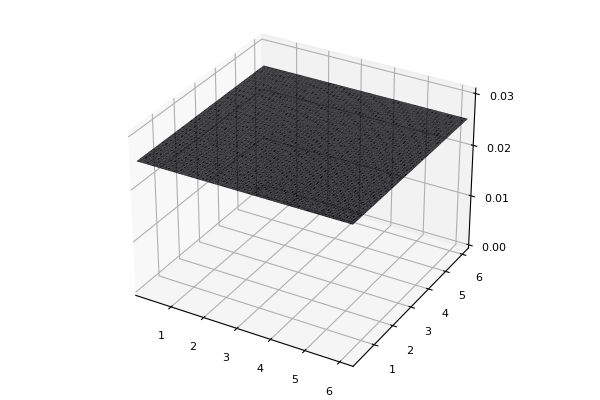

In [6]:
f0s = [f(grid[n,:], range) for n in 1:n_gridpoints];
surface(grid[:,1], grid[:,2], f0s, legend=false, markersize=1)
zlims!(0, 1.2 * (1/(range^2)))

We also need a sample from this initial uniform density $f_0$.

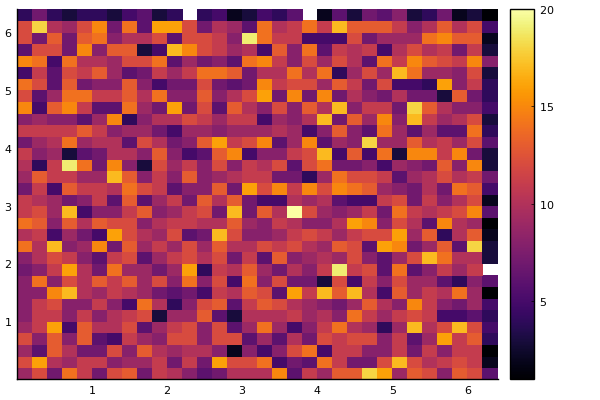

In [7]:
sample_size = 10000;
s = sampledist(sample_size, range);

histogram2d(s[:,1], s[:,2], bins=50)

### A dynamical map
The particular map $S: \mathbb{T}^2 \to \mathbb{T}^2$ chosen to introduce the dynamics is the standard map, or Chirikov–Taylor map, given by
$$
S ([x , y]) := \begin{bmatrix} x + y \\ y + a \sin ( x + y) \end{bmatrix} \mod 2\pi
$$
where $a$ is a parameter which controls the amount of chaos. For the moment we take this to be $a=6$. This map is defined in the function ```S``` which can then be iterated forward across timesteps via ```S_forward```.

We can then easily compare the initial density $f_0$ with a naive estimate of a limiting density $f_*$ by computing the latter with a big value for ```S_forward```.

In [8]:
fstar = S_forward(s, S, 100; map_type="standard");

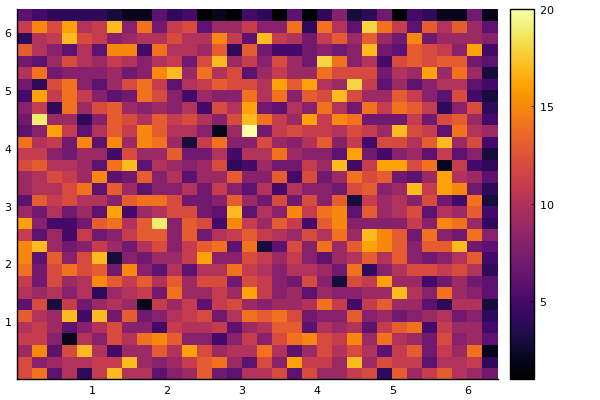

In [9]:
histogram2d(fstar[:,1], fstar[:,2], bins=50)

In this case, the limiting density is precisely the same constant function we started with, so we observe the same uniform distribution for `fstar`.

## Estimating the Perron-Frobenius operator
Having established a model for the dynamics, next we want to estimate the Perron-Frobenius operator,
$$
\mathcal{T} : L^1(X) \to L^1(X)
$$
In particular, we are interested in this operator in the stochastic setting, which can be characterised by the presence of a transition kernel $k(\cdot, \cdot)$. This can be written as
$$
 \mathcal{T} f(y) = \int_X k(S(x), y ) f(x) \, \mathrm{d}x
$$
where $k(x, y) = \phi(x-y)$. 

To estimate this infinite-dimensional operator, we will need to work in a finite-dimensional subspace of $L^1(X)$, which we call $H$. Since $\mathcal{T}$ is linear, it will then suffice to compute its action on a basis. This will allow us to construct a square matrix $T$, which we will take to be our estimate of $\mathcal{T}$, in that $T(H) = \mathcal{T}(H)$.

### A finite basis
To compute $T$, we first must define a finite basis $H$ for $L^1(X)$. For the moment, we take this basis to be a uniform grid of $B$ Gaussian functions $\left\{ \varphi_i \right\}_{i=1}^B$ defined on the state space $X$. These will be of the form
$$
\varphi_i (x) = \phi ( x - z_i ) := \exp \left( - \frac{\| x - z_i \|^2}{\epsilon^2} \right)
$$
where the $z_i$ denote the centres of each RBF and $\epsilon$ is some bandwidth parameter. Each Gaussian function has integral $c = \int_X \varphi_i (x) \, \mathrm{d}x = \pi \epsilon^2$.

In [10]:
ϵ = 0.9;
c = π * ϵ^2;

In [11]:
basis_grid_size = 6;
n_bases = basis_grid_size ^ 2;
basis_locs = creategrid(0, range, basis_grid_size);

These basis functions can be easily visualised by evaluating all grid points against each.

In [12]:
basis_evaluation_matrix = Array{Float64}(undef, n_gridpoints, n_bases);
for b in 1:n_bases
    for n in 1:n_gridpoints
        basis_evaluation_matrix[n, b] = φ(grid[n, :], basis_locs[b, :], ϵ);
    end
end

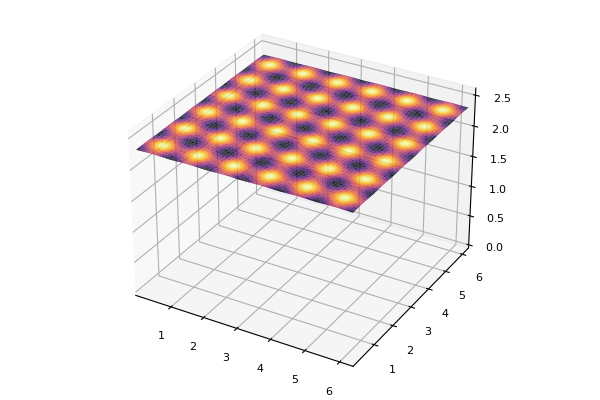

In [13]:
basis_surface = sum(basis_evaluation_matrix, dims=2)[:];
surface(grid[:,1], grid[:,2], basis_surface; legend=false)
zlims!(0,maximum(basis_surface)*1.1)

We get a nice, flat-looking basis surface, which can be used to approximate many functions in $L^1(X)$. To do so, we just take a linear combination of the basis functions. For example:

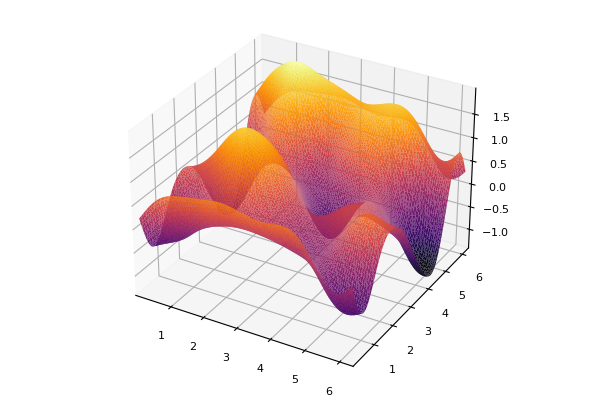

In [14]:
scaling_factor = 3;
β = scaling_factor * (rand(n_bases) .- 0.5);

test_surface = basis_combination(grid, basis_locs, φ, ϵ, β);
surface(grid[:,1], grid[:,2], test_surface; legend=false)

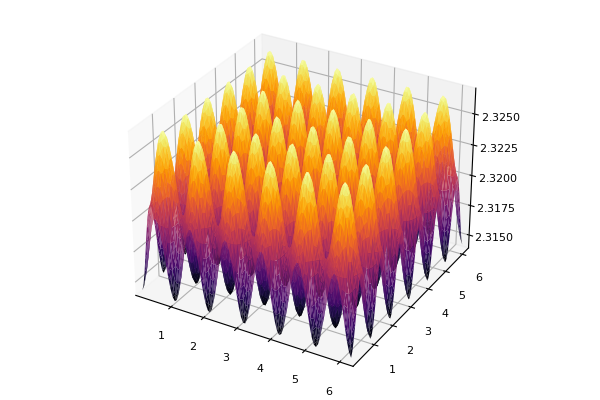

In [15]:
surface(grid[:,1], grid[:,2], basis_surface; legend=false)

...but all the values of the basis surface are nicely packed in a small interval.

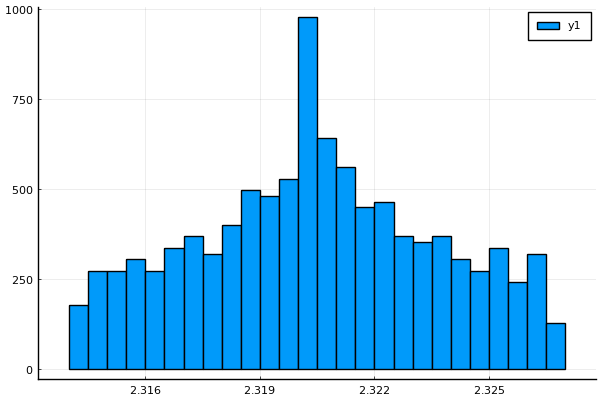

In [16]:
histogram(basis_surface)

### Numerical integration
In order to estimate the integral
$$
    \mathcal{L} f(y) = \int_X k (S(x), y) f(x) \, \mathrm{d}x ,
$$
for some arbitrary function $f\in H$ we will also need an approximate Lebesgue measure for the integral with respect to $\mathrm{d}x$. This will be some weighted combination of all the datapoints (since they are not uniformly spaced), subject to the constraint that obviously each basis function should integrate to $c = \pi\epsilon^2$. We can estimate these weights $w$ using nonnegative least squares, though this will first require an evaluation matrix $\Phi$ on the sample according to the basis functions.

In [17]:
Φ = evaluate_phi(s, basis_locs, φ, ϵ);

In [18]:
C = c * ones(n_bases);
w_av = (range^2) / sample_size;

In [19]:
w, residual, objvalue = nnlsq_pen(Φ, C, w_av, 0.00);

Academic license - for non-commercial use only - expires 2021-08-05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 36 rows, 10036 columns and 360036 nonzeros
Model fingerprint: 0xa536f086
Model has 36 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-11, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+00]
Presolve time: 0.07s
Presolved: 36 rows, 10036 columns, 360036 nonzeros
Presolved model has 36 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.300e+02
 Factor NZ  : 6.660e+02 (roughly 4 MBytes of memory)
 Factor Ops : 1.621e+04 (less than 1 second per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   8.90849734e+06 -8.999766

Since there are more datapoints than bases, and hence $\Phi$ is wider than it is tall, the linear equation is over-specified, so we can attain the constraint exactly.

In [20]:
Φ * w ≈ c * ones(n_bases)

true

The weights should sum to close to $(2\pi)^2$, since this is the area of the state space.

In [21]:
println("Total sum of weights: $(sum(w))")
println("Area of state space: $((2π)^2)")
println("Ratio: $(sum(w) / (2π)^2)")

Total sum of weights: 39.47827358786141
Area of state space: 39.47841760435743
Ratio: 0.9999963520195397


We would also expect that the average weight is close to an equal tesselation of the state space, since all the data points are uniformly distributed.

In [22]:
println("Average weight: $(mean(w))")
println("Equal tesselation size: $(w_av)")

Average weight: 0.003947827358786141
Equal tesselation size: 0.0039478417604357436


We might expect that since the sample points are uniformly distributed, the weights would be almost all equal. This is largely true.

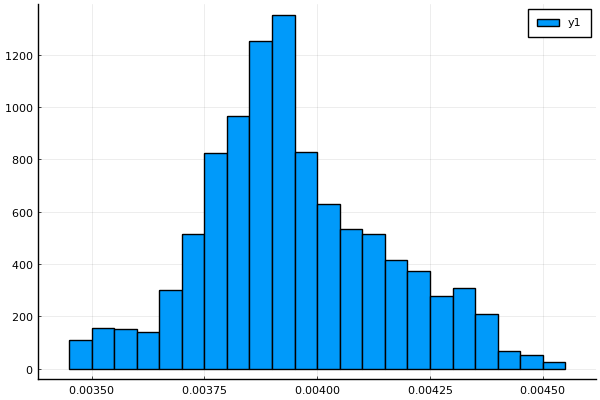

In [23]:
histogram(w)

With these weights, we can now compute the integral $\mathcal{T}f(x)$. In particular, we are interested in computing $\mathcal{T}\varphi_i(x)$ for all $B$ basis functions. Some straightforward arithmetic will show that
\begin{align*}
\mathcal{T}\varphi_i(y) &= \int_X k (Sx, y) \varphi_i(x) \, \mathrm{d}x \\
&= \int_X \phi (Sx - y) \varphi_i(x) \, \mathrm{d}x .
\end{align*}
For convenience, we will use the same stochastic kernel $\phi = \varphi$, where the $\varphi$ are now centered at the image points $S(x) = y$. So the above integral becomes the discrete sum
$$
\mathcal{T}\varphi_i(y) \approx \sum_{n=1}^N \left( w_n \cdot \varphi_i (x_n) \right) \varphi_{y_n} (y)
$$
Hence we can write each of the basis functions $\varphi_i$ as a linear combination of basis functions centered at the image points, $\{ \varphi_{y_n} \}_{n=1}^N$. But we obviously want to be able to write each $\mathcal{T} \varphi_i$ as just a linear combination of the $\varphi_i$. To do this, we will need to 'project' back onto the original subspace $H$ by writing each $\varphi_{y_n}$ itself as a linear combination of the $\varphi_i$.
$$
 \varphi_{y_n} (y) = \sum_{i=1}^B \gamma_i \varphi_i (y)
$$
Where do the weights $\gamma_i$ come from? we will need to calculate them according to the procedure that Gary has outlined. This says that
$$
\varphi_{y_n} (y) \approx Q \varphi_{y_n} (y) = \sum_{j=1}^B \left( \int_{V_j} c_j \varphi_{y_n} \right) \varphi_j (y) .
$$
Each of these integrals is computed over a Voronoi tesselation of the state space $X$, such that each $V_j$ corresponds to a particular basis function $\varphi_j$.

In [24]:
X = s;
Y = S(X; map_type="standard");

In [25]:
Ξ = integrate_phiy(Y, basis_locs, range, 100, φ, ϵ);

What about the weights $c_i$? Following Gary's procedure, these must satisfy
\begin{align*}
    \sum_{i=1}^B \langle \varphi_i , \mathbb{1} \rangle c_i \mathbb{1}_{V_j} &= \mathbb{1} \\
    \sum_{i=1}^B C \cdot c_i \mathbb{1}_{V_j} &= \mathbb{1} \\
    \therefore c_i &= \frac{1}{C}
\end{align*}

This is now everything we need to compute the matrix $L$.

In [26]:
L = construct_L(w, Φ, Ξ, c);

In [27]:
display(L)

36×36 Matrix{Float64}:
 0.0681641   0.0389742   0.0415551   …  0.0245855   0.0228892   0.024603
 0.0449473   0.0262617   0.0116223      0.00533244  0.00507032  0.00522466
 0.00874612  0.00928127  0.00385166     0.0104027   0.00870846  0.0040863
 0.00551929  0.00518099  0.00428849     0.0293303   0.0438978   0.0331768
 0.0258856   0.0242834   0.0237929      0.0389261   0.0629217   0.0790853
 0.0542421   0.0481128   0.0548561   …  0.0473393   0.0474807   0.0607388
 0.0287078   0.00990285  0.0116293      0.00535891  0.00512769  0.00521034
 0.00969609  0.00330715  0.00141194     0.00913028  0.00403117  0.0021206
 0.00544191  0.00399292  0.0039262      0.0477588   0.0308208   0.017918
 0.0280388   0.0244722   0.0226128      0.0677015   0.0703134   0.0603314
 0.0575656   0.0551991   0.0555883   …  0.0464699   0.0550823   0.0626006
 0.0439522   0.0368288   0.0479195      0.0232846   0.0229737   0.0250461
 0.00369248  0.00131118  0.00205499     0.00406818  0.00198488  0.00142129
 ⋮            

## Checking the results
Now that we have an estimate of $L$, we can start evaluating it.

### Plotting the spectrum
We expect that $L$ should have a leading unit eigenvalue, and all the remaining eigenvalues should have modulus less than one.

In [28]:
λ, Λ = ordered_eigendecomp(L);

In [29]:
display(λ[1])

0.9999984095714772 + 0.0im

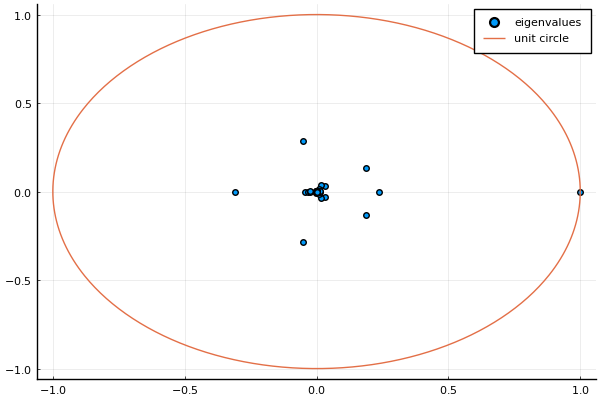

In [30]:
u, v = real.(λ), imag.(λ);
xc, yc = cos.(LinRange(0, 2π, 500)), sin.(LinRange(0, 2π, 500));

scatter(u, v, label="eigenvalues")
plot!(xc, yc, label="unit circle")

Happily, this does indeed appear to be the case.

### Row stochasticity
We also expect that the estimate should be row-stochastic.

In [31]:
sum(L, dims=2)

36×1 Matrix{Float64}:
 0.9999984095760674
 0.9999984093925198
 0.9999984094982487
 0.999998409571977
 0.9999984098419624
 0.9999984099972413
 0.9999984095033889
 0.999998409100351
 0.9999984091802713
 0.999998409701779
 0.9999984094964495
 0.9999984097469307
 0.9999984093602802
 ⋮
 0.9999984098587389
 0.9999984095990339
 0.9999984092318751
 0.9999984092390231
 0.999998409546765
 0.9999984097488894
 0.999998409277466
 0.9999984096434371
 0.9999984096186819
 0.9999984098971446
 0.999998409766418
 0.9999984099021098

It indeed sums to the same number, which is of course the leading unit eigenvalue.

### Invariant density
We know that the leading eigenvector will specify the linear combination of basis functions which represents the invariant density.

In [32]:
α = real.(Λ[:,1]);

In [33]:
display(α)

36-element Vector{Float64}:
 -0.16666666667736943
 -0.1666666666335738
 -0.16666666664724689
 -0.1666666666641261
 -0.16666666672015068
 -0.16666666674980296
 -0.16666666666583613
 -0.16666666658352836
 -0.16666666659075927
 -0.16666666668857597
 -0.16666666666397797
 -0.16666666671128455
 -0.166666666629265
  ⋮
 -0.166666666720097
 -0.16666666667502283
 -0.16666666659915794
 -0.1666666665984654
 -0.16666666665771893
 -0.16666666669953414
 -0.16666666662665086
 -0.16666666667371652
 -0.16666666665626179
 -0.16666666671319677
 -0.16666666670262711
 -0.16666666673226313

In [34]:
invariant_density = basis_combination(grid, basis_locs, φ, ϵ, α);

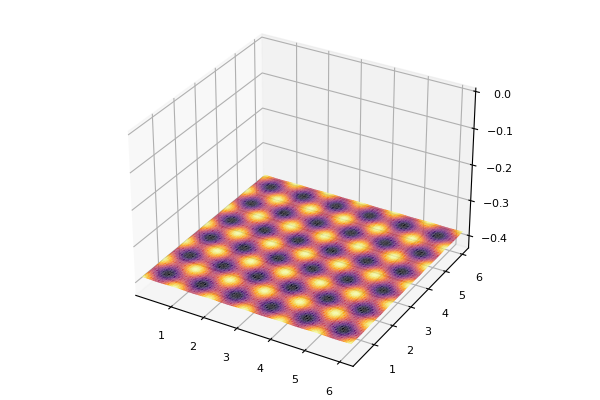

In [36]:
surface(grid[:,1], grid[:,2], invariant_density; legend=false)

if mean(invariant_density) > 0
    zlims!(0, maximum(invariant_density)*1.1)
else
    zlims!(minimum(invariant_density)*1.1, 0)
end

This looks pretty flat, which is good.

## Conclusions
We have a reasonably functional procedure. Now it is time to experiment with different model parameters.